# Importing functions

In [ ]:
#import functions
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import math
import pandas as pd
import torch.nn.functional as F
import random
import torch.optim as optim

# Creating our NN structure

In [ ]:
class ThreeLayerModel(nn.Module):
    def __init__(self):
        super(ThreeLayerModel, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 64)  # Input size: 2, Output size: 64
        self.layer2 = nn.Linear(64, 128)  # Input size: 64, Output size: 128
        self.layer3 = nn.Linear(128, 1)  # Input size: 128, Output size: 1

    def forward(self, x):
        x = torch.tanh(self.layer1(x))  # Apply Tanh activation after layer1
        x = torch.tanh(self.layer2(x))  # Apply Tanh activation after layer2
        x = self.layer3(x)  # Output layer, no activation function

        return x

# Create an instance of the model
model_1 = ThreeLayerModel()

# Import data

I wrote this code in google colab so this is how i imported them however if u are using local u import the data differently.

In [ ]:
pilotoutput = pd.read_csv("pilotoutput.csv",header=None)
pilotoutput_1=torch.squeeze(torch.tensor(pilotoutput.values, dtype=torch.float32))


pitcherror = pd.read_csv("pitcherror.csv",header=None)
pitcherror_1= torch.squeeze(torch.tensor(pitcherror.values, dtype=torch.float32))

params = (pd.read_csv("params_data4.csv",header=None))
params_1= (torch.tensor(params.values, dtype=torch.float32)) #tld,tlg,tau,kp

xpilot = pd.read_csv("xp.csv",header=None)
xpilot_1=torch.squeeze(torch.tensor(xpilot.values, dtype=torch.float32))[:,0].squeeze()

# check the shape to make sure it makes sense
pilotoutput_1.shape,pitcherror_1.shape,params_1.shape,xpilot_1.shape

(torch.Size([10001]),
 torch.Size([10001]),
 torch.Size([1, 4]),
 torch.Size([10001]))

## general data analysis/cleaning

In [ ]:
# define the true values to just for comparison
tld_true=params_1[0,0]
tlg_true=params_1[0,1]
kp_true = params_1[0,3]
tau_true = params_1[0,2]
tld_true,tlg_true,tau_true,kp_true

(tensor(0.1862), tensor(0.4553), tensor(0.2413), tensor(0.3152))

In [ ]:
# define time vector
Ts = 0.01
Tfinal = 100
length = Tfinal/Ts

# time is a necessary component that way you can take the time derivative of the NN outputs
time = torch.arange(0, Tfinal + Ts, Ts)
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

In [ ]:
subset = int(0.3*length)
# define training points over the entire domain, for the physics loss
t_train = time[:subset].view(-1,1).requires_grad_(True)
pilotoutput_train=pilotoutput_1[:subset]
pitcherror_train=pitcherror_1[:subset]
xpilot_train=xpilot_1[:subset]

# define the testing points
t_test = time.view(-1,1)
pilotoutput_test =pilotoutput_1
pitcherror_test = pitcherror_1

In [ ]:
X_train = torch.cat((t_train,pitcherror_train.unsqueeze(1)),dim=1)
X_test = torch.cat((t_test,pitcherror_test.unsqueeze(1)),dim=1)

X_train.shape, X_test.shape

(torch.Size([3000, 2]), torch.Size([10001, 2]))

In [ ]:
torch.manual_seed(123)

# define how our NN will learn the parameters aka learning rates

In [ ]:
# treat the tld, tlag, kp as learnable parameters. we are not estimating tau.

# give the initial value of the parameters to start the estimation
tld =  torch.nn.Parameter(torch.tensor(0.01, requires_grad=True))
tld_init = tld.detach().reshape(1)

tlg =  torch.nn.Parameter(torch.tensor(0.01, requires_grad=True))
tlg_init = tlg.detach().reshape(1)

tau = tau_true

kp =  torch.nn.Parameter(torch.tensor(0.01, requires_grad=True))
kp_init = kp.detach().reshape(1)


#track the variables history
tlds=[]
tlgs=[]
kps=[]


# Example learning rates
lr_model_1 = 1e-2  # Learning rate for model_1 parameters plus kp and tlead
lr_others_2 = 5e-2 # learning rate for tlg

# Define the optimizer with parameter groups
optimiser = torch.optim.Adam([
    {'params': list(model_1.parameters())+[kp]+[tld], 'lr': lr_model_1},
    {'params': [tlg], 'lr': lr_others_2}
])

'''
overall this learning rate strucutre was found to work better, however maybe more tuning could be done.

From thesis document:
" account for different model parameters
and different pilot model parameters having different influence on the learning process a non
uniform learning rate was found useful as the Neural Network parameters along with Kp and
TLead used a learning rate of 1x10^−2 and TLag used a learning rate of 5x10^−2. "

'''

# define the number of epochs
epochs = 401
pause = (epochs-1)/10

loss_history=[]
loss1_history=[]
loss2_history=[]
loss3_history = []

# Create helper function to create delayed data

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def transport_delay(data, tau, time_step, initial_value=pitcherror_train[0]):
    """
    Applies a transport delay to a 1D tensor of time series data.

    Parameters:
    - data: 1D PyTorch tensor containing the time series data.
    - tau: The delay in seconds.
    - time_step: The time step between consecutive samples in seconds.
    - initial_value: The value to fill in the delayed portion of the tensor.

    Returns:
    - delayed_data: The tensor with the applied delay.
    """
    if not isinstance(data, torch.Tensor):
        raise ValueError("data should be a PyTorch tensor")

    if data.dim() != 1:
        raise ValueError("data should be a 1D tensor")

    # Calculate the number of samples to delay
    delay_steps = int(round(tau.item() / time_step))

    # Ensure delay_steps is non-negative
    delay_steps = max(delay_steps, 0)

    # Create a tensor with the same shape as data, filled with initial_value
    delayed_data = torch.full_like(data, initial_value)

    # Apply the delay by shifting the data tensor
    if delay_steps < len(data):
        delayed_data[delay_steps:] = data[:-delay_steps]
    else:
        # If delay_steps is larger than the data length, return all initial values
        delayed_data = torch.full_like(data, initial_value)

    return delayed_data

In [ ]:
# sample output of how to use the function
delayed_data = transport_delay(pilotoutput_train, tau, Ts)
delayed_data.shape

# NN training loop

In [ ]:
for i in range(epochs):

  optimiser.zero_grad()

  # compute each term of the PINN loss function above
  # using the following hyperparameters:
  lambda1,lambda2,lambda3=1,1,1

  # Loss 1: boundary condition x(0)=0
  u = model_1(X_train[0])
  loss1=torch.abs(u-0)
  loss1_history.append(loss1.item())


  # Loss 2: ODE loss
  u = model_1(X_train)
  dudt = torch.autograd.grad(u, t_train, torch.ones_like(u), create_graph=True)[0]
  #dudt = torch.autograd.grad(u, t_train, torch.ones_like(u), create_graph=True)[0]
  delayed_data = transport_delay(pilotoutput_train, tau, Ts)
  loss2 = torch.mean(torch.abs(dudt + ((1/tlg)*u) - pitcherror_train))
  #loss2 = torch.mean(torch.abs(dudt + ((1/tlg)*u) - delayed_data))
  loss2_history.append(loss2.item())


  # Loss 3: estimated pilot output loss
  u=model_1(X_train)
  pilotestimated_train = ( ((-kp/(tlg*tlg))*(tlg-tld)*u) - ((kp*tld/tlg)*pitcherror_train) )
  #pilotestimated_train = ( ((-kp/(tlg*tlg))*(tlg-tld)*u) - ((kp*tld/tlg)*delayed_data) )
  loss3=torch.mean(torch.abs((pilotoutput_train-pilotestimated_train)))
  loss3_history.append(loss3.item())

  # backpropagate joint loss, take optimiser step
  loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 #+ loss4
  loss_history.append(loss.item())
  # print training progress
  if i%pause==0:
    print(f"Epoch number: {i}, Loss: {loss.item()}, TLd:     {tld.item()}, TLg:     {tlg.item()}, Kp:     {kp.item()}")


  loss.backward(retain_graph=True)

  # constrain the learning of the parameters
  tld.data = torch.clamp(tld.data, 0.01, 3)
  tlg.data = torch.clamp(tlg.data, 0.01, 3)
  kp.data = torch.clamp(kp.data, 0.01, 2)

  optimiser.step()

  # record pilot parameter values
  tlds.append(tld.item())
  tlgs.append(tlg.item())
  kps.append(kp.item())

Epoch number: 0, Loss: 36.419891357421875, TLd:     0.009999999776482582, TLg:     0.009999999776482582, Kp:     0.009999999776482582
Epoch number: 40, Loss: 2.405057907104492, TLd:     0.019252393394708633, TLg:     0.41163381934165955, Kp:     0.009988177567720413
Epoch number: 80, Loss: 2.334367036819458, TLd:     0.020969612523913383, TLg:     0.42199352383613586, Kp:     0.018161235377192497
Epoch number: 120, Loss: 2.3576507568359375, TLd:     0.024692583829164505, TLg:     0.4222484230995178, Kp:     0.033865850418806076
Epoch number: 160, Loss: 2.3162155151367188, TLd:     0.032548848539590836, TLg:     0.4222142696380615, Kp:     0.056574832648038864
Epoch number: 200, Loss: 2.3230948448181152, TLd:     0.04712722450494766, TLg:     0.4221309721469879, Kp:     0.09108185768127441
Epoch number: 240, Loss: 2.231433153152466, TLd:     0.07231561839580536, TLg:     0.4217645823955536, Kp:     0.14695391058921814
Epoch number: 280, Loss: 2.221928834915161, TLd:     0.11304528266191

# plotting results

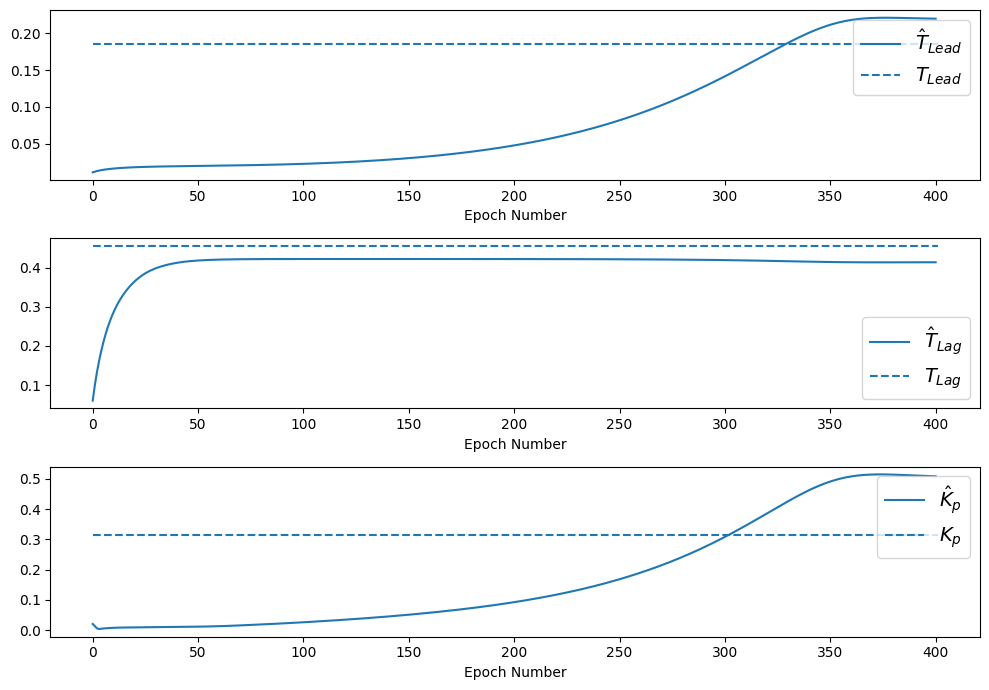

In [ ]:
#have to rerun the code to get new outputs that will get u the same graphs as in my thesis. theyre different here because i made some tweaks to the code and have not reran it with the final corrections

fig, axs = plt.subplots(3,1, figsize=(10, 7))

axs[0].plot(torch.tensor(tlds), label=r'$\hat{T}_{Lead}$')
axs[0].hlines(tld_true,0,len(tlds),label=r'$T_{Lead}$',linestyles='dashed')
axs[0].set_xlabel('Epoch Number')
axs[0].legend(fontsize='14')

axs[1].plot(torch.tensor(tlgs), label=r'$\hat{T}_{Lag}$')
axs[1].hlines(tlg_true,0,len(tlds),label=r'$T_{Lag}$',linestyles='dashed')
axs[1].set_xlabel('Epoch Number')
axs[1].legend(fontsize='14')

axs[2].plot(torch.tensor(kps), label=r'$\hat{K}_{p}$')
axs[2].hlines(kp_true,0,len(tlds),label=r'$K_{p}$',linestyles='dashed')
axs[2].set_xlabel('Epoch Number')
axs[2].legend(fontsize='14')

# Adjust layout
plt.tight_layout()

plt.show()

## printing the final values

In [ ]:
print(f"{(tld-tld_true)**2:0.4f}")

0.0011


In [ ]:
print(f"{(tlg-tlg_true)**2:0.5f}")

0.00172


In [ ]:
print(f"{(kp-kp_true)**2:0.5f}")

0.03727


# plot the estimated pilot output

<ipython-input-19-25855180b781>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pilotestimated =torch.tensor(( ((-kp/(tlg*tlg))*(tlg-tld)*torch.squeeze(u)) - ((kp*tld/tlg)*pitcherror_test_tau) ))


<Figure size 640x480 with 0 Axes>

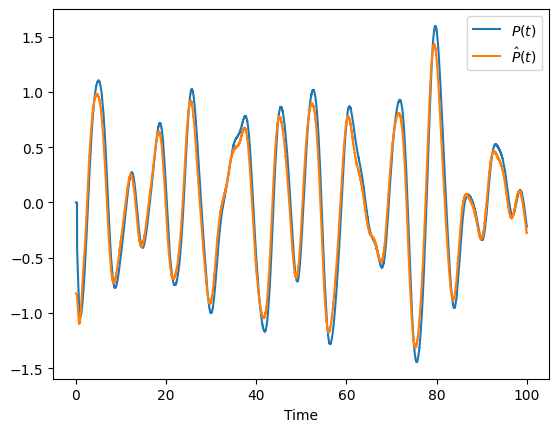

In [ ]:
plt.figure()
u = model_1(X_test).detach()

pitcherror_test_tau = transport_delay(pitcherror_test, tau, Ts)

pilotestimated =torch.tensor(( ((-kp/(tlg*tlg))*(tlg-tld)*torch.squeeze(u)) - ((kp*tld/tlg)*pitcherror_test_tau) ))
plt.figure()
#plt.title(f"Pilot Output True and Estimated Comparison")
plt.plot(t_test,pilotoutput_test,label=r"$P(t)$")
plt.plot(t_test,pilotestimated.detach().numpy() ,label=r"$\hat{P}(t)$")
plt.legend()
plt.xlabel("Time")
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error
mean_squared_error(pilotoutput_test,pilotestimated.detach().numpy())

0.02133125